# Results Summary Analysis (Reader-Friendly)

This notebook turns `results_summary_by_settings.csv` into a compact, readable analysis report.

## What you will get
- Data quality checks and coverage overview
- Method-level long-format table for comparisons
- Main comparison plot under a configurable filter slice
- Best setting per method and pairwise deltas
- Optional CSV exports for downstream reporting


## 1) Setup

Imports and display settings used throughout the notebook.


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)
pd.set_option('display.precision', 3)


## 2) Load Data

We load the summary CSV and preview the first few rows.


In [5]:
CSV_PATH = Path('results_summary_by_settings.csv')
assert CSV_PATH.exists(), f'Missing file: {CSV_PATH}'

df = pd.read_csv(CSV_PATH)
print(f'Loaded {CSV_PATH} with shape: {df.shape}')
display(df.head(5))


Loaded results_summary_by_settings.csv with shape: (204, 24)


,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,n_rows,n_files,n_seeds,goat_mean,goat_std,goat_count,goatcw_mean,goatcw_std,goatcw_count,eta_mean,eta_std,eta_count,ours_fr_mean,ours_fr_std,ours_fr_count,seeds
0,colored_mnist,NaN,0,0,pseudo,prototypes,bic,False,3,3,3,61.340,0.352,3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0|1|2
1,colored_mnist,NaN,0,1,pseudo,prototypes,bic,False,3,3,3,72.227,2.870,3,58.117,0.952,3,53.347,5.704,3,71.020,4.038,3,0|1|2
2,colored_mnist,NaN,0,1,pseudo,pseudo,bic,False,3,3,3,72.227,2.870,3,61.387,5.706,3,41.887,3.677,3,68.777,5.253,3,0|1|2
3,colored_mnist,NaN,0,2,pseudo,prototypes,bic,False,3,3,3,75.137,3.559,3,70.163,1.901,3,50.327,3.266,3,74.733,3.110,3,0|1|2
4,colored_mnist,NaN,0,2,pseudo,pseudo,bic,False,3,3,3,75.137,3.559,3,70.427,2.636,3,50.463,2.536,3,73.240,2.721,3,0|1|2


## 3) Quick Data Dictionary

Key columns used in the analysis:
- `dataset`, `degree`, `gt`, `gen`: dataset and experiment setting axes
- `label_source`, `em_match`, `em_select`, `em_ensemble`: labeling/EM configuration
- `*_mean`, `*_std`, `*_count`: method-specific aggregated accuracy stats
- `seeds`, `n_seeds`: seed metadata for reproducibility checks


## 4) Sanity Checks

Check basic coverage and consistency of seed metadata.


In [6]:
def parse_seeds(s):
    if pd.isna(s) or s == '':
        return []
    return [int(x) for x in str(s).split('|') if x != '']

df['seed_list'] = df['seeds'].apply(parse_seeds)
df['seed_count_from_list'] = df['seed_list'].apply(len)

dataset_values = sorted(df['dataset'].dropna().unique().tolist())
gt_values = sorted(df['gt'].dropna().unique().tolist())
gen_values = sorted(df['gen'].dropna().unique().tolist())
seed_mismatch = int((df['n_seeds'] != df['seed_count_from_list']).sum())

print('Datasets:', dataset_values)
print('gt values:', gt_values)
print('gen values:', gen_values)
print('Rows where n_seeds != parsed seeds:', seed_mismatch)



Datasets: ['colored_mnist', 'covtype', 'portraits', 'rotated_mnist']
gt values: [0, 1, 2, 3]
gen values: [0, 1, 2, 3]
Rows where n_seeds != parsed seeds: 0


## 5) Coverage by Setting

How many summary rows/files we have for each `(dataset, degree, gt, gen)` combination.


In [7]:
coverage = (
    df.groupby(['dataset', 'degree', 'gt', 'gen'], dropna=False)
      .agg(
          n_setting_rows=('dataset', 'size'),
          n_files=('n_files', 'sum'),
          n_seeds=('n_seeds', 'max'),
      )
      .reset_index()
      .sort_values(['dataset', 'degree', 'gt', 'gen'])
)



## 6) Convert to Long Format (Method-Centric)

A tidy table makes ranking, plotting, and pairwise deltas much simpler.


In [8]:
METHODS = ['goat', 'goatcw', 'eta', 'ours_fr']

long_rows = []
for m in METHODS:
    cols = [
        'dataset', 'degree', 'gt', 'gen',
        'label_source', 'em_match', 'em_select', 'em_ensemble',
        'seeds', 'n_rows', 'n_files', 'n_seeds',
        f'{m}_mean', f'{m}_std', f'{m}_count',
    ]
    sub = df[cols].copy()
    sub = sub.rename(columns={f'{m}_mean': 'acc_mean', f'{m}_std': 'acc_std', f'{m}_count': 'acc_count'})
    sub['method'] = m
    long_rows.append(sub)

df_long = pd.concat(long_rows, ignore_index=True)
df_long = df_long.dropna(subset=['acc_mean']).reset_index(drop=True)

print('Long-format shape:', df_long.shape)



Long-format shape: (732, 16)


In [9]:
import pandas as pd

df_all = pd.read_csv("results_all_with_settings.csv")

seed_view = df_all[
    (df_all['dataset'] == 'portraits') &
    (df_all['gt'] == 0) &
    (df_all['gen'] == 1) &
    (df_all['label_source'] == 'pseudo') &
    (df_all['em_match'] == 'prototypes') &
    (df_all['em_select'] == 'bic') &
    (df_all['em_ensemble'] == False)
][['seed','goat','goatcw','eta','ours_fr','file_path','file_mtime']].sort_values('seed')

seed_view


,seed,goat,goatcw,eta,ours_fr,file_path,file_mtime
182,0,76.00,78.00,78.55,78.60,logs/portraits/s0/test_acc_dim2048_int0_gen1_p...,1771861465
214,1,76.55,78.25,78.15,78.75,logs/portraits/s1/test_acc_dim2048_int0_gen1_p...,1771468616
246,2,75.90,78.30,77.05,78.35,logs/portraits/s2/test_acc_dim2048_int0_gen1_p...,1771469376


## 7) Main Comparison Slice (Editable)

Set the filter below to define your primary comparison scenario.


In [10]:
FILTERS = {
    'label_source': 'pseudo',
    'em_match': 'prototypes',
    'em_select': 'bic',
    'em_ensemble': False,
}

sel = df_long.copy()
# for k, v in FILTERS.items():
#     sel = sel[sel[k] == v]

print('Active filters:', FILTERS)
print('Rows after filtering:', len(sel))



Active filters: {'label_source': 'pseudo', 'em_match': 'prototypes', 'em_select': 'bic', 'em_ensemble': False}
Rows after filtering: 732


## 8) Plot: Accuracy vs `gen` by Dataset (Fixed `gt`)

This is the main visual comparison used in most summaries.


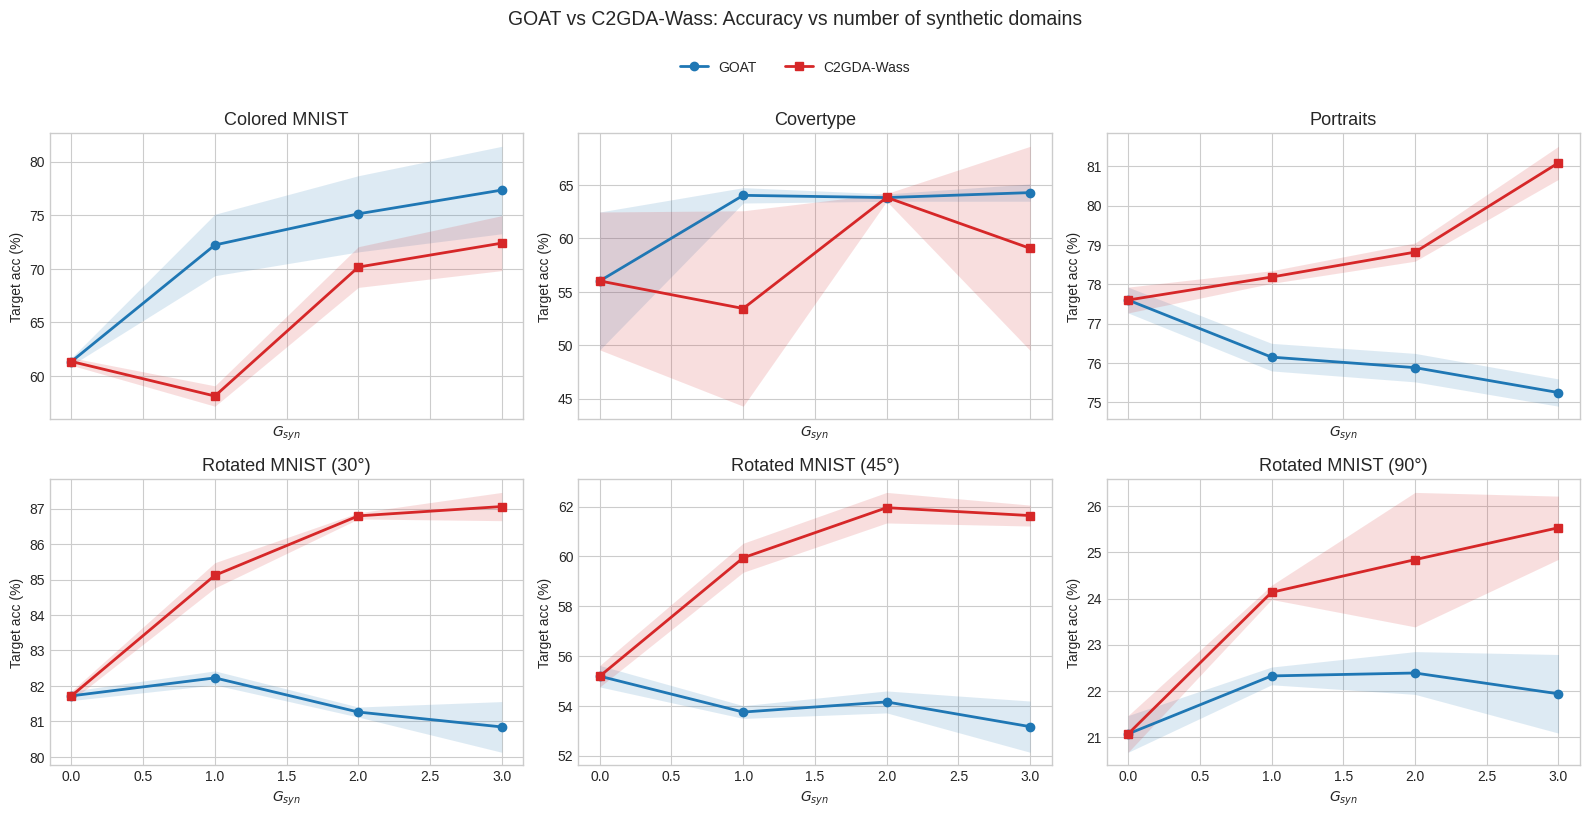

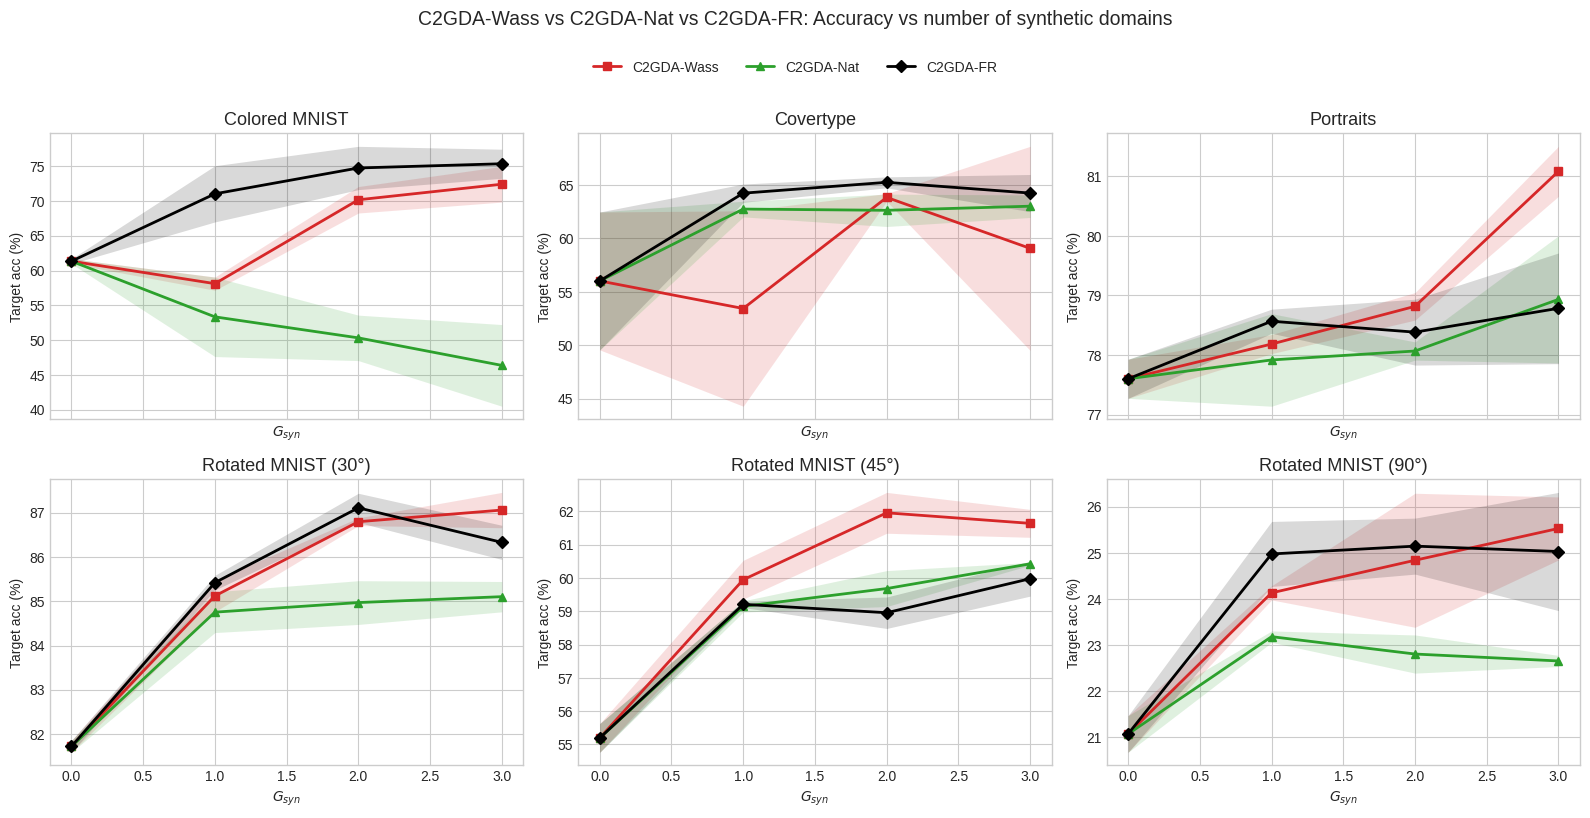

In [11]:
GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()
# plot_df = plot_df[~plot_df['dataset'].str.contains('covtype', case=False, na=False)].copy()  # optional

def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']

plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)

# Pretty names for subplot titles
dataset_title = {
    'colored_mnist': 'Colored MNIST',
    'portraits': 'Portraits',
    'covtype': 'Covertype',
    'rot_mnist_t15': 'Rotated MNIST (15°)',
    'rot_mnist_t30': 'Rotated MNIST (30°)',
    'rot_mnist_t45': 'Rotated MNIST (45°)',
    'rot_mnist_t60': 'Rotated MNIST (60°)',
    'rot_mnist_t75': 'Rotated MNIST (75°)',
    'rot_mnist_t90': 'Rotated MNIST (90°)',
}
def pretty_ds(name):
    return dataset_title.get(name, name.replace('_', ' ').title())

datasets = sorted(plot_df['dataset_label'].unique().tolist())
# datasets = sorted(plot_df['dataset_label'].unique().tolist())
datasets = [d for d in datasets if d != 'rot_mnist_t60']  # drop 60° to keep 2x3

method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}
import os
os.makedirs("figures_main", exist_ok=True)

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(x, y, linewidth=2.0, label=method_name[m], **method_style[m])
            ax.fill_between(x, y - y_std, y + y_std, color=method_style[m]['color'], alpha=0.15, linewidth=0)

        ax.set_title(pretty_ds(ds), fontsize=13)
        ax.set_xlabel(r'$G_{syn}$')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs number of synthetic domains', y=1.07, fontsize=14)
    fig.tight_layout()

    # save
    slug = group_title.lower().replace(' ', '_').replace('-', '')
    fig.savefig(f"figures_main/{slug}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"figures_main/{slug}.pdf", bbox_inches="tight")

    plt.show()


In [12]:
import pandas as pd
import numpy as np

SEEDS = {0,1,2}
STD_TH = 4.0           # same as before: only inspect high-variance settings
Z_TH = 1.0             # seed is outlier if |seed_acc - mean| / std >= Z_TH

s = pd.read_csv("results_summary_by_settings.csv")
all_df = pd.read_csv("results_all_with_settings.csv")

methods = ["goat","goatcw","eta","ours_fr"]

# long + best
rows = []
for m in methods:
    t = s[['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble',
           'n_rows','n_files','n_seeds','seeds',f'{m}_mean',f'{m}_std',f'{m}_count']].copy()
    t = t.rename(columns={f'{m}_mean':'acc_mean', f'{m}_std':'acc_std', f'{m}_count':'acc_count'})
    t['method'] = m
    rows.append(t)
df_long = pd.concat(rows, ignore_index=True)

# Use exact-match filters for speed/stability
f = df_long[
    (~df_long['em_ensemble']) &
    (df_long['em_match'] == 'prototypes') &
    (df_long['em_select'] == 'bic')
].copy()

rank_df = f.sort_values(
    ['dataset','degree','gt','gen','method','acc_mean'],
    ascending=[True,True,True,True,True,False]
)
best = rank_df.groupby(['dataset','degree','gt','gen','method'], dropna=False).head(1).reset_index(drop=True)

all_f = all_df[
    (~all_df['em_ensemble']) &
    (all_df['em_match'] == 'prototypes') &
    (all_df['em_select'] == 'bic')
].copy()

q_all = best[(best['n_files'] <= 3) & (best['acc_std'] > STD_TH)].copy()
print("q_all rows:", len(q_all))

def degree_mask(df, val):
    if pd.isna(val):
        return df['degree'].isna()
    return df['degree'] == val

outlier_rows = []

for _, r in q_all.iterrows():
    m = r["method"]

    sub = all_f[
        (all_f["dataset"] == r["dataset"]) &
        degree_mask(all_f, r["degree"]) &
        (all_f["gt"] == r["gt"]) &
        (all_f["gen"] == r["gen"]) &
        (all_f["label_source"] == r["label_source"]) &
        (all_f["em_match"] == r["em_match"]) &
        (all_f["em_select"] == r["em_select"]) &
        (all_f["em_ensemble"] == r["em_ensemble"])
    ][["seed", m, "file_path", "file_mtime"]].dropna(subset=[m]).copy()

    if sub.empty:
        continue

    mean_val = float(r["acc_mean"])
    std_val = float(r["acc_std"])

    sub["acc_mean"] = mean_val
    sub["acc_std"] = std_val
    sub["dev"] = (sub[m] - mean_val).abs()
    sub["z"] = sub["dev"] / max(std_val, 1e-12)
    sub["direction"] = np.where(sub[m] < sub["acc_mean"], "low", "high")

    bad = sub[sub["z"] >= Z_TH].copy()   # all outlier seeds
    if bad.empty:
        continue

    bad["dataset"] = r["dataset"]
    bad["degree"] = r["degree"]
    bad["gt"] = int(r["gt"])
    bad["gen"] = int(r["gen"])
    bad["method"] = m
    bad = bad.rename(columns={m: "seed_acc"})

    outlier_rows.append(
        bad[["dataset","degree","gt","gen","method","seed","seed_acc",
             "acc_mean","acc_std","dev","z","direction","file_path","file_mtime"]]
    )

outlier_df = pd.concat(outlier_rows, ignore_index=True) if outlier_rows else pd.DataFrame(
    columns=["dataset","degree","gt","gen","method","seed","seed_acc",
             "acc_mean","acc_std","dev","z","direction","file_path","file_mtime"]
)

outlier_df = outlier_df.sort_values(
    ["dataset","degree","gt","gen","method","z","seed"],
    ascending=[True,True,True,True,True,False,True]
).reset_index(drop=True)

print("Total outlier seeds:", len(outlier_df))
display(outlier_df)


q_all rows: 21
Total outlier seeds: 21


,dataset,degree,gt,gen,method,seed,seed_acc,acc_mean,acc_std,dev,z,direction,file_path,file_mtime
0,colored_mnist,NaN,0,1,eta,1,47.01,53.347,5.704,6.337,1.111,low,logs/color_mnist/s1/test_acc_dim2048_int0_gen1...,1766346757
1,colored_mnist,NaN,0,1,ours_fr,1,66.38,71.020,4.038,4.640,1.149,low,logs/color_mnist/s1/test_acc_dim2048_int0_gen1...,1766346757
2,colored_mnist,NaN,0,3,eta,0,39.75,46.373,5.865,6.623,1.129,low,logs_rerun/color_mnist/s0/test_acc_dim2048_int...,1771868368
3,colored_mnist,NaN,0,3,goat,0,82.07,77.357,4.085,4.713,1.154,high,logs_rerun/color_mnist/s0/test_acc_dim2048_int...,1771868368
4,colored_mnist,NaN,1,1,eta,2,76.38,70.080,5.898,6.300,1.068,high,logs_rerun/color_mnist/s2/test_acc_dim2048_int...,1771868977
5,colored_mnist,NaN,1,1,goatcw,2,61.54,70.923,8.135,9.383,1.153,low,logs_rerun/color_mnist/s2/test_acc_dim2048_int...,1771868977
6,colored_mnist,NaN,1,2,eta,1,61.23,66.220,4.458,4.990,1.119,low,logs_rerun/color_mnist/s1/test_acc_dim2048_int...,1771867450
7,colored_mnist,NaN,2,2,eta,1,64.71,73.057,7.285,8.347,1.146,low,logs_rerun/color_mnist/s1/test_acc_dim2048_int...,1771870636
8,colored_mnist,NaN,2,3,eta,1,70.47,74.850,4.133,4.380,1.060,low,logs/color_mnist/s1/test_acc_dim2048_int2_gen3...,1766354207
9,colored_mnist,NaN,3,2,eta,2,75.58,70.753,4.752,4.827,1.016,high,logs/color_mnist/s2/test_acc_dim2048_int3_gen2...,1767820885


In [13]:
import os
import pandas as pd
from pathlib import Path

# Map summary dataset names -> experiment_refrac CLI names / log subdirs
DATASET_MAP = {
    "colored_mnist": {"cli": "color_mnist", "log_dir": "color_mnist"},
    "covtype": {"cli": "covtype", "log_dir": "covtype"},
    "portraits": {"cli": "portraits", "log_dir": "portraits"},
    # rotated_mnist skipped here (needs rotation-angle/degree handling)
}

SPREAD_TH = 12.0

# Build per-group seed->acc map from outlier_df itself
group_cols = ["dataset", "gt", "gen", "method"]
seed_map = (
    outlier_df.groupby(group_cols, dropna=False)
    .apply(lambda g: {int(s): float(a) for s, a in zip(g["seed"], g["seed_acc"])})
    .to_dict()
)

rerun_list = []

for r in outlier_df.itertuples(index=False):
    ds, gt, gen = str(r.dataset), int(r.gt), int(r.gen)
    method = str(r.method)

    if ds not in DATASET_MAP:
        continue

    out_seed = int(r.seed)          # fixed
    out_val = float(r.seed_acc)     # fixed
    vals = seed_map.get((ds, gt, gen, method), {})

    if method == "goatcw" and len(vals) >= 3:
        items = sorted(vals.items(), key=lambda kv: kv[1])  # ascending
        spread = items[-1][1] - items[0][1]
        max_val = items[-1][1]

        # Rule A: outlier is highest -> rerun lower seeds
        if abs(out_val - max_val) < 1e-9:
            for s, _ in items[:-1]:
                rerun_list.append((ds, s, gt, gen))
            continue

        # Rule B: large spread -> rerun two lowest seeds
        if spread >= SPREAD_TH:
            for s, _ in items[:2]:
                rerun_list.append((ds, s, gt, gen))
            continue

    # default
    rerun_list.append((ds, out_seed, gt, gen))

rerun_list = sorted(set(rerun_list), key=lambda x: (x[0], x[2], x[3], x[1]))
print(rerun_list)
print("Total experiments to rerun after applying rules:", len(rerun_list))

final_view = pd.DataFrame(rerun_list, columns=["dataset", "seed", "gt", "gen"])
# display(final_view.sort_values(["dataset", "gt", "gen", "seed"]).reset_index(drop=True))

# -----------------------------
# Write shell script
# -----------------------------
script_path = Path("./rerun_outliers.sh")

lines = []
lines.append("#!/usr/bin/env bash")
lines.append("set -euo pipefail")
lines.append("cd ~/GOAT")
lines.append("")
lines.append('LOG_ROOT="${LOG_ROOT:-logs_rerun}"')
lines.append('PLOT_ROOT="${PLOT_ROOT:-plots_rerun}"')
lines.append("")

lines.append("pick_gpu() {")
lines.append("  if ! command -v nvidia-smi >/dev/null 2>&1; then")
lines.append("    echo 0")
lines.append("    return 0")
lines.append("  fi")
lines.append("  nvidia-smi --query-gpu=index,memory.free,utilization.gpu --format=csv,noheader,nounits | \\")
lines.append("  awk -F',' '{")
lines.append("    gsub(/ /, \"\", $1); gsub(/ /, \"\", $2); gsub(/ /, \"\", $3);")
lines.append("    # sort key: free desc, util asc")
lines.append("    printf \"%012d %03d %s\\n\", $2, 1000-$3, $1")
lines.append("  }' | sort -r | head -1 | awk '{print $3}'")
lines.append("}")

lines.append("")

lines.append("run_exp() {")
lines.append('  local cli_ds="$1" seed="$2" gt="$3" gen="$4"')
lines.append("  local gpu")
lines.append('  gpu="$(pick_gpu)"')
lines.append('  echo "[GPU ${gpu}] ${cli_ds} seed=${seed} gt=${gt} gen=${gen}"')
lines.append("  OMP_NUM_THREADS=4 MKL_NUM_THREADS=4 OPENBLAS_NUM_THREADS=4 NUMEXPR_NUM_THREADS=4 \\")
lines.append('  PYTORCH_CUDA_ALLOC_CONF="${PYTORCH_CUDA_ALLOC_CONF:-expandable_segments:True}" \\')
lines.append('  CUDA_VISIBLE_DEVICES="${gpu}" \\')
lines.append('  python experiment_refrac.py --plot-root "${PLOT_ROOT}" --log-root "${LOG_ROOT}" \\')
lines.append('    --dataset "${cli_ds}" --label-source pseudo --em-match prototypes \\')
lines.append('    --seed "${seed}" --gt-domains "${gt}" --generated-domains "${gen}" --num-workers 0')
lines.append("}")
lines.append("")

for ds, s, gt, gen in rerun_list:
    cli_ds = DATASET_MAP[ds]["cli"]
    log_ds = DATASET_MAP[ds]["log_dir"]

    lines.append(
        f'rm -f "${{LOG_ROOT}}/{log_ds}/s{s}/test_acc_dim54_int{gt}_gen{gen}_pseudo_prototypes_bic.txt" '
        f'"${{LOG_ROOT}}/{log_ds}/s{s}/test_acc_dim54_int{gt}_gen{gen}_pseudo_prototypes_bic_curves.jsonl" '
        f'"${{LOG_ROOT}}/{log_ds}/s{s}/test_acc_dim2048_int{gt}_gen{gen}_pseudo_prototypes_bic.txt" '
        f'"${{LOG_ROOT}}/{log_ds}/s{s}/test_acc_dim2048_int{gt}_gen{gen}_pseudo_prototypes_bic_curves.jsonl"'
    )

    lines.append(
        f'rm -f "${{PLOT_ROOT}}/{log_ds}/s{s}/test_acc_dim54_int{gt}_gen{gen}_pseudo_prototypes_bic.png" '
        f'"${{PLOT_ROOT}}/{log_ds}/s{s}/test_acc_dim2048_int{gt}_gen{gen}_pseudo_prototypes_bic.png"'
    )

    lines.append(f'run_exp "{cli_ds}" "{s}" "{gt}" "{gen}"')
    lines.append("")

lines.append("python collect_result.py --log-bases logs,logs_rerun")
lines.append("")

script_path.write_text("\n".join(lines), encoding="utf-8")
os.chmod(script_path, 0o755)

print("Saved:", script_path)
print("Run with:")
print(f"bash {script_path}")

display(
    outlier_df[
        ["dataset", "gt", "gen", "method", "seed", "seed_acc", "acc_mean", "acc_std"]
    ]
)


[('colored_mnist', 1, 0, 1), ('colored_mnist', 0, 0, 3), ('colored_mnist', 2, 1, 1), ('colored_mnist', 1, 1, 2), ('colored_mnist', 1, 2, 2), ('colored_mnist', 1, 2, 3), ('colored_mnist', 2, 3, 2), ('colored_mnist', 1, 3, 3), ('covtype', 2, 0, 0), ('covtype', 1, 0, 1), ('covtype', 2, 0, 3), ('covtype', 2, 1, 0), ('covtype', 0, 1, 1), ('covtype', 1, 1, 1), ('covtype', 0, 1, 2), ('covtype', 0, 1, 3)]
Total experiments to rerun after applying rules: 16
Saved: rerun_outliers.sh
Run with:
bash rerun_outliers.sh


/tmp/ipykernel_2636113/1777605054.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: {int(s): float(a) for s, a in zip(g["seed"], g["seed_acc"])})


,dataset,gt,gen,method,seed,seed_acc,acc_mean,acc_std
0,colored_mnist,0,1,eta,1,47.01,53.347,5.704
1,colored_mnist,0,1,ours_fr,1,66.38,71.020,4.038
2,colored_mnist,0,3,eta,0,39.75,46.373,5.865
3,colored_mnist,0,3,goat,0,82.07,77.357,4.085
4,colored_mnist,1,1,eta,2,76.38,70.080,5.898
5,colored_mnist,1,1,goatcw,2,61.54,70.923,8.135
6,colored_mnist,1,2,eta,1,61.23,66.220,4.458
7,colored_mnist,2,2,eta,1,64.71,73.057,7.285
8,colored_mnist,2,3,eta,1,70.47,74.850,4.133
9,colored_mnist,3,2,eta,2,75.58,70.753,4.752


## 9) Best Setting per Method and Scenario

For each `(dataset, degree, gt, gen, method)`, keep the highest `acc_mean` row.


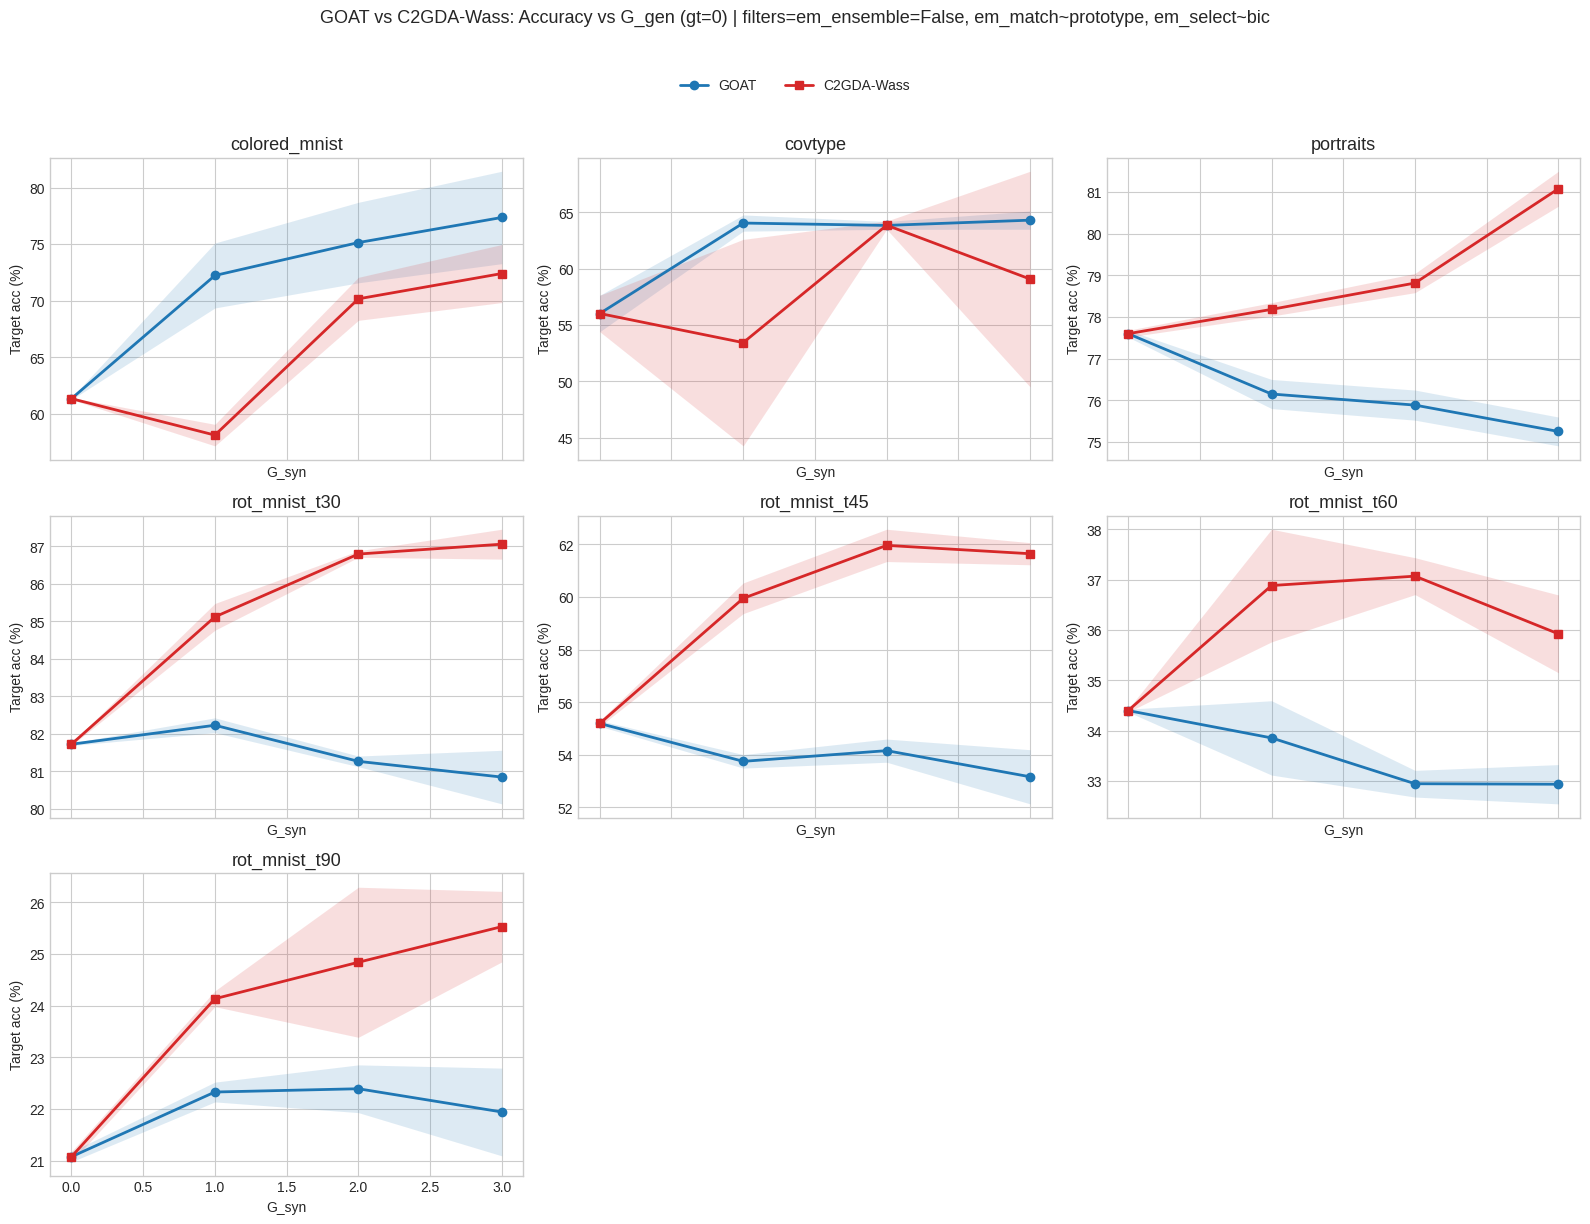

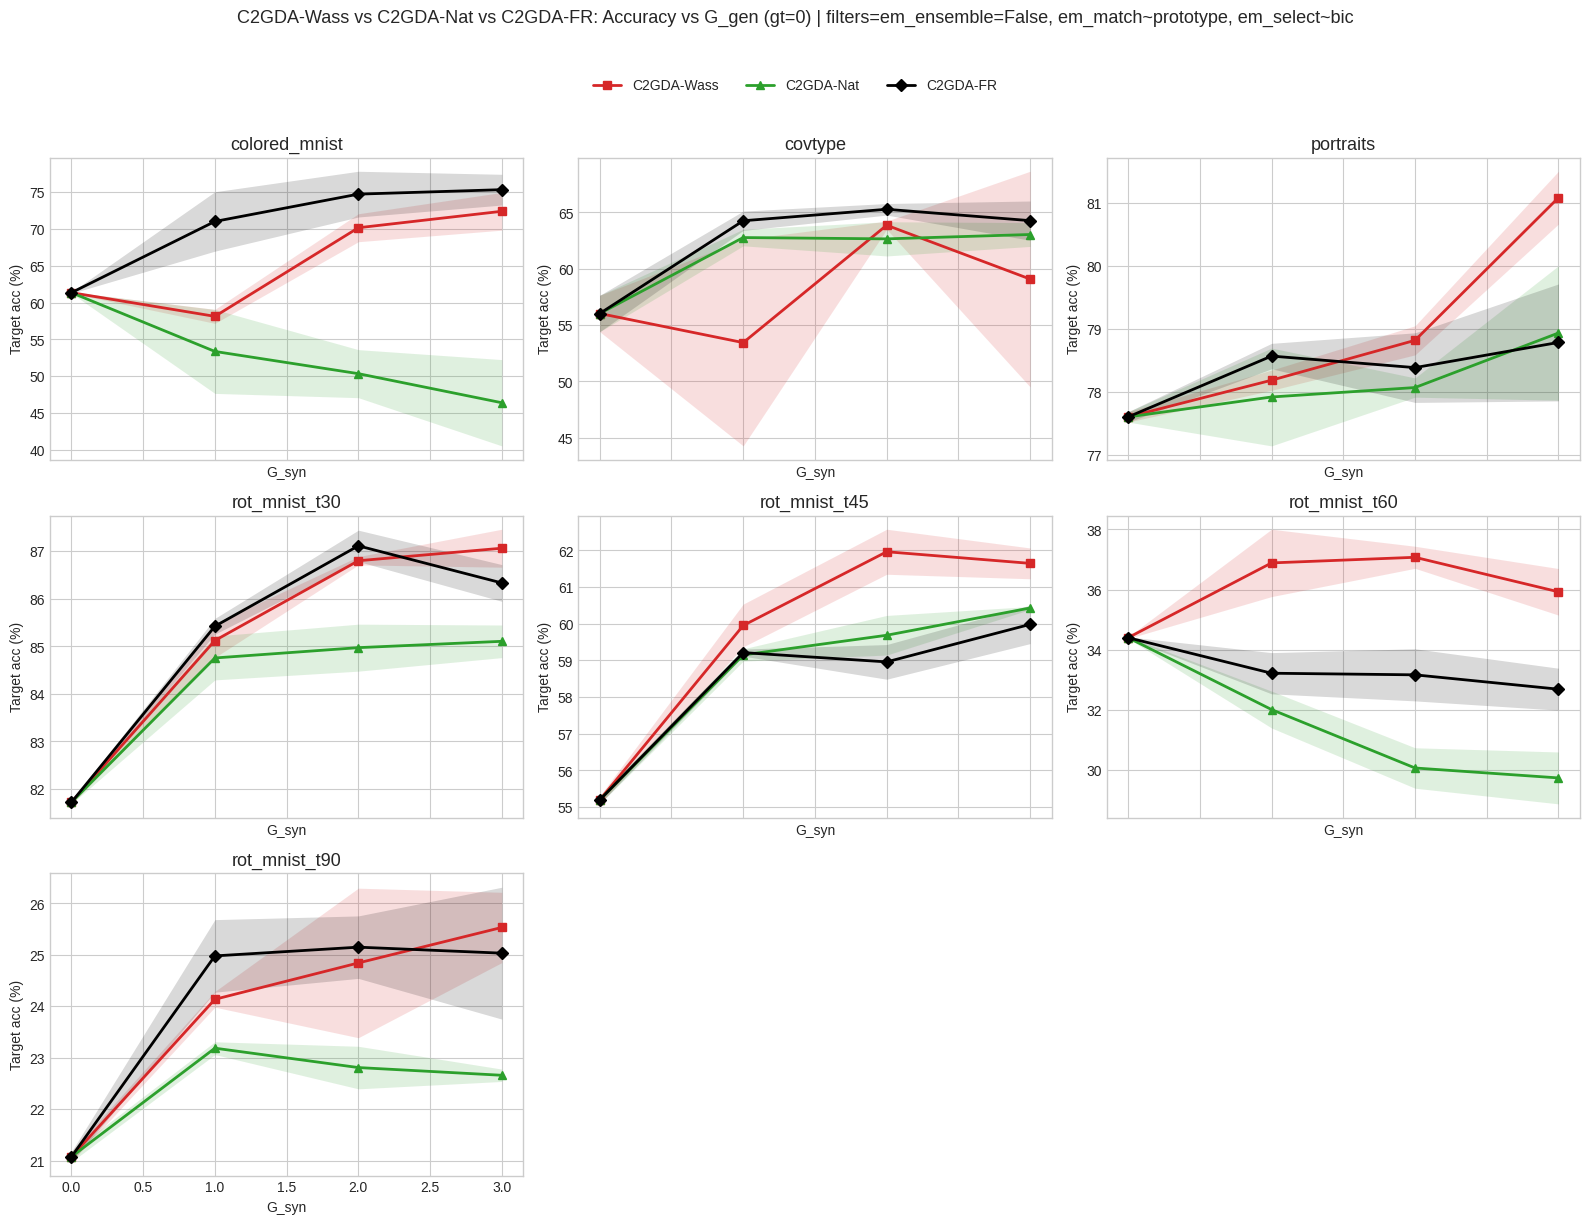

In [14]:
if 'df_long' not in globals():
    raise NameError("`df_long` is not defined. Run the long-table preparation cell first.")
df_long = df_long[(~df_long['em_ensemble']) & df_long['em_match'].str.contains('prototype', na=False) & df_long['em_select'].str.contains('bic', na=False)]
rank_df = df_long.sort_values(
    ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
    ascending=[True, True, True, True, True, False],
)
best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

best[best['dataset'].str.contains('colored_mnist')][
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds']
]

best[
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds','acc_mean','acc_std']
]


GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()


def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']


plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)
datasets = sorted(plot_df['dataset_label'].unique().tolist())
method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(
                x,
                y,
                linewidth=2.0,
                label=method_name[m],
                **method_style[m],
            )
            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                color=method_style[m]['color'],
                alpha=0.15,
                linewidth=0,
            )
        ax.set_title(ds, fontsize=13)
        ax.set_xlabel('G_syn')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs G_gen (gt={GT_TO_PLOT}) | filters={FILTERS_DESC}', y=1.07, fontsize=13)
    fig.tight_layout()
    plt.show()




## 10) Pairwise Method Deltas (Split)

Group A compares `goatcw` against `goat`; Group B compares `eta` and `ours_fr` against `goatcw`.


In [15]:
wide = df_long.pivot_table(
    index=['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble','seeds'],
    columns='method',
    values='acc_mean',
    aggfunc='first',
).reset_index()

if {'goat', 'goatcw'}.issubset(wide.columns):
    wide['delta_goatcw_minus_goat'] = wide['goatcw'] - wide['goat']
    display(
        wide[['dataset','degree','gt','gen','goat','goatcw','delta_goatcw_minus_goat']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group A delta: goat/goatcw')

if {'goatcw', 'eta', 'ours_fr'}.issubset(wide.columns):
    wide['delta_eta_minus_goatcw'] = wide['eta'] - wide['goatcw']
    wide['delta_fr_minus_goatcw'] = wide['ours_fr'] - wide['goatcw']
    display(
        wide[['dataset','degree','gt','gen','goatcw','eta','ours_fr','delta_eta_minus_goatcw','delta_fr_minus_goatcw']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group B deltas: goatcw/eta/ours_fr')


method,dataset,degree,gt,gen,goat,goatcw,delta_goatcw_minus_goat
0,rotated_mnist,30.0,0,0,81.720,NaN,NaN
1,rotated_mnist,30.0,0,1,82.227,85.120,2.893
2,rotated_mnist,30.0,0,2,81.263,86.797,5.533
3,rotated_mnist,30.0,0,3,80.843,87.060,6.217
4,rotated_mnist,30.0,1,0,87.830,NaN,NaN
5,rotated_mnist,30.0,1,1,87.260,87.553,0.293
6,rotated_mnist,30.0,1,2,87.947,88.643,0.697
7,rotated_mnist,30.0,1,3,88.417,89.230,0.813
8,rotated_mnist,30.0,2,0,91.533,NaN,NaN
9,rotated_mnist,30.0,2,1,89.943,88.123,-1.820


method,dataset,degree,gt,gen,goatcw,eta,ours_fr,delta_eta_minus_goatcw,delta_fr_minus_goatcw
0,rotated_mnist,30.0,0,0,NaN,NaN,NaN,NaN,NaN
1,rotated_mnist,30.0,0,1,85.120,84.753,85.420,-0.367,0.300
2,rotated_mnist,30.0,0,2,86.797,84.970,87.110,-1.827,0.313
3,rotated_mnist,30.0,0,3,87.060,85.103,86.330,-1.957,-0.730
4,rotated_mnist,30.0,1,0,NaN,NaN,NaN,NaN,NaN
5,rotated_mnist,30.0,1,1,87.553,88.697,89.343,1.143,1.790
6,rotated_mnist,30.0,1,2,88.643,88.803,89.623,0.160,0.980
7,rotated_mnist,30.0,1,3,89.230,89.067,89.990,-0.163,0.760
8,rotated_mnist,30.0,2,0,NaN,NaN,NaN,NaN,NaN
9,rotated_mnist,30.0,2,1,88.123,88.703,89.803,0.580,1.680


In [16]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from qualitative_vae_compare import FeatureToImageVAE

ckpt_path = "analysis_outputs/qualitative_mnist_target60/seed0/feature_vae_target60_z128_ssl0p0_seed0.pt"
enc_dir = "analysis_outputs/qualitative_mnist_target60/seed0/encoded_cache"
out_png = "analysis_outputs/qualitative_mnist_target60/seed0/feature_vae_feature_samples.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(ckpt_path, map_location=device)

feature_dim = int(ckpt["feature_dim"])
z_dim = int(ckpt["latent_dim"])

model = FeatureToImageVAE(feature_dim=feature_dim, latent_dim=z_dim, image_dim=28*28).to(device)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# Load source+target encoded features (same feature space used to train feature_vae)
e_src = torch.load(os.path.join(enc_dir, "encoded_0.pt"), weights_only=False)
e_tgt = torch.load(os.path.join(enc_dir, "encoded_60.pt"), weights_only=False)

F_all = torch.cat([e_src.data.cpu().float(), e_tgt.data.cpu().float()], dim=0)

# Sample feature vectors and decode
n = 32
rng = np.random.default_rng(0)
idx = rng.choice(len(F_all), size=n, replace=False)
feat = F_all[idx].to(device)

with torch.no_grad():
    imgs = model.decode_from_features(feat, deterministic=True).cpu()  # (N,1,28,28)

# Plot
cols = 8
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.4, rows*1.4))
axes = axes.flatten()
for i in range(n):
    axes[i].imshow(imgs[i, 0], cmap="gray", vmin=0, vmax=1)
    axes[i].axis("off")
for i in range(n, len(axes)):
    axes[i].axis("off")

fig.tight_layout()
os.makedirs(os.path.dirname(out_png), exist_ok=True)
fig.savefig(out_png, dpi=250, bbox_inches="tight")
plt.close(fig)
print("Saved:", out_png)


RuntimeError: Error(s) in loading state_dict for FeatureToImageVAE:
	Missing key(s) in state_dict: "image_dec.decode.0.weight", "image_dec.decode.0.bias", "image_dec.decode.2.weight", "image_dec.decode.2.bias", "image_dec.decode.2.running_mean", "image_dec.decode.2.running_var", "image_dec.decode.3.weight", "image_dec.decode.3.bias", "image_dec.decode.5.weight", "image_dec.decode.5.bias", "image_dec.decode.5.running_mean", "image_dec.decode.5.running_var", "image_dec.decode.6.weight", "image_dec.decode.6.bias", "image_dec.decode.8.weight", "image_dec.decode.8.bias", "image_dec.decode.8.running_mean", "image_dec.decode.8.running_var", "image_dec.decode.9.weight", "image_dec.decode.9.bias", "image_dec.decode.11.weight", "image_dec.decode.11.bias", "image_dec.decode.11.running_mean", "image_dec.decode.11.running_var", "image_dec.fc4.weight", "image_dec.fc4.bias". 
	Unexpected key(s) in state_dict: "image_dec.0.weight", "image_dec.0.bias", "image_dec.2.weight", "image_dec.2.bias", "image_dec.4.weight", "image_dec.4.bias". 

## 11) High-Variance Rows (Diagnostics)

These rows are useful to inspect unstable settings.


In [20]:
print("all datasets in all_df:", sorted(all_df['dataset'].dropna().unique()))
print("after prototype+bic filter:", sorted(all_f['dataset'].dropna().unique()))
print("after std/missing selection:", sorted(q_all['dataset'].dropna().unique()))


all datasets in all_df: ['covtype']
after prototype+bic filter: ['covtype']
after std/missing selection: ['colored_mnist', 'covtype']


## 12) Optional Exports

Uncomment and run this cell when you want CSV outputs for reports or scripts.


In [12]:
OUT_DIR = Path('analysis_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_long.to_csv(OUT_DIR / 'results_summary_long.csv', index=False)
best.to_csv(OUT_DIR / 'best_setting_per_method.csv', index=False)
wide.to_csv(OUT_DIR / 'pairwise_deltas.csv', index=False)

print('Wrote:', OUT_DIR)


Wrote: analysis_outputs


## 13) Key Takeaways (Fill After Running)

Use this section to record final conclusions from the run:
- Which method wins most often?
- Which datasets/settings are most sensitive to `gen`?
- Where is variance too high for confident claims?
